In [19]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import datetime as dt
import pandas as pd 
import matplotlib.dates as mdates

In [21]:
def fetch_data(ticker, start_date="2010-01-01"):
    end_date = dt.datetime.now().strftime('%Y-%m-%d')  
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']

company_name = 'NVDA'
appl_data = fetch_data(company_name)
print(appl_data)


[*********************100%***********************]  1 of 1 completed

Date
2010-01-04      0.462250
2010-01-05      0.469000
2010-01-06      0.472000
2010-01-07      0.462750
2010-01-08      0.463750
                 ...    
2024-08-26    126.459999
2024-08-27    128.300003
2024-08-28    125.610001
2024-08-29    117.589996
2024-08-30    119.370003
Name: Close, Length: 3690, dtype: float64


In [23]:
# Normalize and prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_scaled = scaler.fit_transform(appl_data.values.reshape(-1, 1))

# Function to create data sequences for LSTM training
def create_dataset(data, look_back=100):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Creating the dataset for training
X, Y = create_dataset(aapl_scaled)

# Splitting data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [25]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0068 - val_loss: 2.7309e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.3480e-04 - val_loss: 2.4419e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7163e-04 - val_loss: 2.2018e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3225e-04 - val_loss: 1.9146e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.9704e-04 - val_loss: 1.6572e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.1823e-04 - val_loss: 1.9955e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.6552e-04 - val_loss: 1.4642e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.5486e-04 - val_loss: 1.2538e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.3880e-04 - val_loss: 4.4872e-04
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 3.3571e-04 - val_loss: 1.1391e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.1395e-04 - 

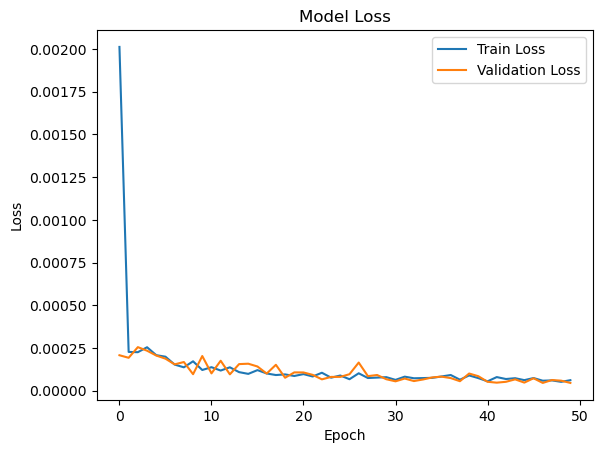

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


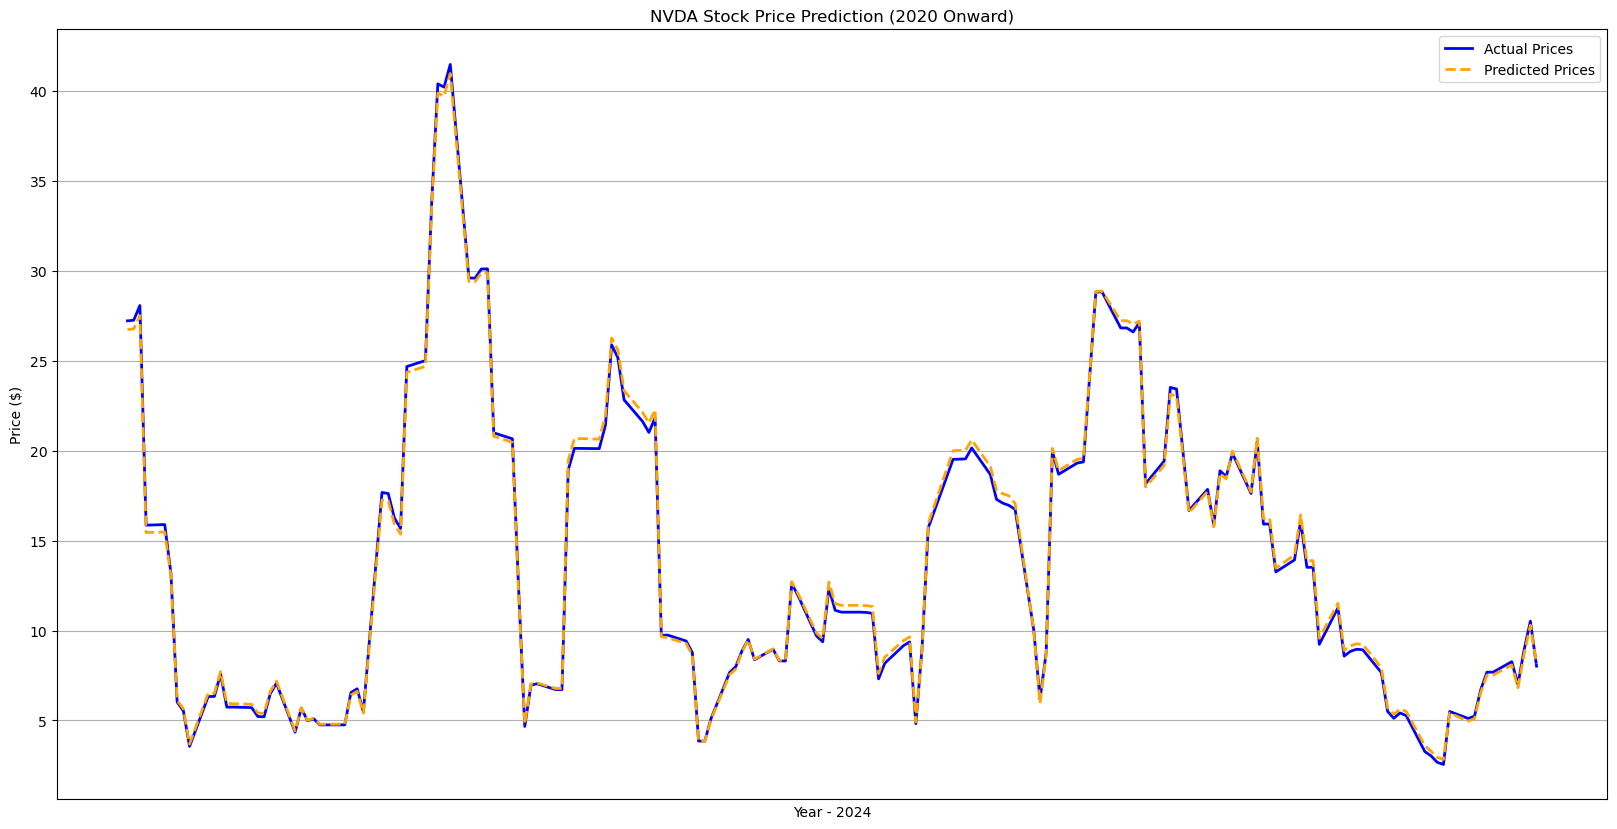

In [13]:
# Generate predictions for both training and validation data
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Inverse scaling to transform predictions back to original scale
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
actual_train = scaler.inverse_transform(Y_train)
actual_val = scaler.inverse_transform(Y_val)

# Combining train and validation sets to plot them in context
all_predictions = np.concatenate((train_predictions.flatten(), val_predictions.flatten()))
all_actual = np.concatenate((actual_train.flatten(), actual_val.flatten()))

# Create the full timeline of dates for both training and validation periods
combined_dates = appl_data.index[-len(all_actual):]  

# Filter data to only include from 2024 onwards
mask = combined_dates >= "2024-01-01"
filtered_dates = combined_dates[mask]
filtered_actual = all_actual[mask]
filtered_predictions = all_predictions[mask]

# Plotting the actual prices and the predictions with years on x-axis
plt.figure(figsize=(20, 10))

# Smoothing the lines by plotting the rolling mean
rolling_window_size = 10  # Defines the window for rolling mean
smoothed_actual = pd.Series(filtered_actual).rolling(window=rolling_window_size).mean()
smoothed_predictions = pd.Series(filtered_predictions).rolling(window=rolling_window_size).mean()

# Plotting with thicker lines for better visibility
plt.plot(filtered_dates, smoothed_actual, label='Actual Prices', linestyle='-', color='blue', linewidth=2)  # Increased linewidth
plt.plot(filtered_dates, smoothed_predictions, label='Predicted Prices', linestyle='--', color='orange', linewidth=2)  # Increased linewidth


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  

plt.title(f'{company_name} Stock Price Prediction (2020 Onward)')
plt.xlabel('Year - 2024')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
days_to_predict = 2


latest_data = aapl_scaled[-300:]  

future_predictions = []


for _ in range(days_to_predict):

    latest_data_reshaped = latest_data.reshape((1, latest_data.shape[0], 1))
    
    next_day_prediction = model.predict(latest_data_reshaped)
    
    next_day_prediction_actual = scaler.inverse_transform(next_day_prediction)
    
    future_predictions.append(next_day_prediction_actual[0, 0])
    
    latest_data = np.append(latest_data, next_day_prediction)[1:]


print("Predicted stock prices for the next two days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: ${price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted stock prices for the next two days:
Day 1: $116.74
Day 2: $115.21


In [33]:
import yfinance as yf

# List of banks and tech companies
companies = [
    'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'HSBC', 'BCS', 'DB', 'BNPQY', 'UBS',
    'RY', 'TD', 'MUFG', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA',
    'ORCL', 'INTC', 'CSCO', 'IBM', 'CRM', 'ADBE', 'NFLX', 'AMD'
]


data = {}
end_date = dt.datetime.now().strftime('%Y-%m-%d') 
for company in companies:
    data[company] = yf.download(company, start="2010-01-01", end=end_date)
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [35]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Define a function to create and train the model
def train_model(company_data, company_name):
    # Prepare the data
    close_prices = company_data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)

    def create_dataset(data, look_back=100):
        X, Y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            Y.append(data[i + look_back, 0])
        return np.array(X), np.array(Y)
    
    X, Y = create_dataset(scaled_data)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build the model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, Y, epochs=50, batch_size=32, verbose=1)
    
    # Save the model for each company
    model.save(f'{company_name}_model.h5')

# Train and save models for each company
for company in companies:
    print(f"Training model for {company}")
    train_model(data[company], company)


Training model for JPM
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0293
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4478e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3157e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9151e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.2615e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.6000e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1468e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1474e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.2834e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9373e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5130e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0687e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3256e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0560e-04
Ep

Training model for BAC
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0294
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.6400e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7751e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4235e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1542e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5391e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5922e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9112e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4396e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.3449e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.4347e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7221e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0292e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0614e-04
Ep

Training model for WFC
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0643
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0016
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0016
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0013
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0010
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.0624e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.4072e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.4121e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.7372e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.0050e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.7394e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.9357e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4276e-04
Epoch 15/50
113/113 ━━

Training model for C
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0341
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0020
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0013
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0012
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0012
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.3189e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.6336e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.7169e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.2927e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.4721e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.3772e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3924e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1704e-04
Epoch 15/50
113/113 ━━

Training model for GS
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0262
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.1908e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9260e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6955e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9813e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.6032e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8802e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0829e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7907e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5609e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4395e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5103e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3359e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.5675e-04
Ep

Training model for MS
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0243
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.0744e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.8337e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.6557e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0717e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7961e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4672e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8973e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.6660e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3231e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4174e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8358e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8222e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0834e-04
Ep

Training model for HSBC
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0526
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.9450e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.4616e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.1654e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 8.1372e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.3872e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.1053e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 7.6389e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.3610e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.2799e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.0933e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4732e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1179e-04
Epoch 

Training model for BCS
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0301
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.8643e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.5394e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.6555e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.8872e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.7009e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.2247e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.0830e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1782e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.5284e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.5634e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5002e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1980e-04
Epoch 

Training model for DB
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0155
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.5273e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.2747e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3982e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6923e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1402e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4379e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4799e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1907e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.9828e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.6124e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8713e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6091e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3327e-04
Ep

Training model for BNPQY
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0572
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0023
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0022
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0017
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0014
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0013
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0012
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.6617e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.2910e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.4560e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.6748e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.1461e-04
Epoch 15/50
113/113 ━━━━━━━━━━━━━━

Training model for UBS
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0238
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 9.1759e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.9359e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8672e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.5269e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 7.4562e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.5042e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7098e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4726e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.3769e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.3306e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7658e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.3260e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.4408e-04
Ep

Training model for RY
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0320
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.0052e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3953e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.7562e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.6064e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.2489e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7734e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4830e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4880e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4486e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5511e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4336e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3530e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.2865e-04
Ep

Training model for TD
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0215
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3688e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.8522e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.6617e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4633e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1749e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9108e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0654e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7226e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7398e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0766e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0455e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3409e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.5691e-04
Ep

Training model for MUFG
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0201
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.8205e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.3916e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.9648e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.2096e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.5721e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.5127e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7490e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3105e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9576e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9814e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6761e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8876e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3146e-04
Ep

Training model for AAPL
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0148
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.4928e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1599e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0393e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.6722e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4041e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.5796e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3942e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2972e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0054e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9978e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9431e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6902e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6393e-04
Ep

Training model for MSFT
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0144
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0020e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9026e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0337e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9533e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6557e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8042e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9559e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4533e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3445e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - loss: 1.8794e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 1.5002e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6904e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.3952e-04
Ep

Training model for GOOGL
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0091
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.9693e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2421e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8985e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3768e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0260e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1315e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9024e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7537e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.2084e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5783e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7849e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8051e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.5436e-04
Ep

Training model for AMZN
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0335
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1375e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9279e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.3250e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.9223e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7201e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7854e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3020e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.0151e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1290e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.7410e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1720e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5416e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3197e-04
Ep

Training model for META
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0229
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.0205e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3233e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.5134e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0722e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1296e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3762e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3257e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2718e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.5653e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7911e-04
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0204e-04
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.3135e-04
Epoch 14/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6087e-04
Epoch 15/50
94/94 ━━━━━━━━━━━━

Training model for TSLA
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0110
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3382e-04
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.8413e-04
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.2780e-04
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5159e-04
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3932e-04
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.9250e-04
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.3928e-04
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.0924e-04
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.8389e-04
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.6511e-04
Epoch 12/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.1209e-04
Epoch 13/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8872e-04
Epoch 14/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7256e-04
Ep

Training model for NVDA
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0054
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4206e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8807e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4269e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.5746e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3782e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7325e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.4519e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.8305e-05
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0093e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2181e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0024e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.0010e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.5406e-05
Ep

Training model for ORCL
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0126
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9813e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.3735e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0398e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.6455e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.4182e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.8502e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.4042e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4150e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2849e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5470e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.9925e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0527e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9331e-04
Ep

Training model for INTC
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0221
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0011
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 8.6259e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.5986e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.2635e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.3518e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.8904e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.5204e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.0010e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.1890e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.0030e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9730e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.9822e-04
Epoch 15/5

Training model for CSCO
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0393
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.3745e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.1294e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6805e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.4521e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7687e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.6302e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.8182e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6570e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.4654e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.0009e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.8818e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4281e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.7968e-04
Ep

Training model for IBM
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0468
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0014
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0014
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0011
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.6719e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.9877e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.3224e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.1051e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.5212e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.9415e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3428e-04
Epoch 15/50
113/113 ━━━━━━

Training model for CRM
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0383
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.7821e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.1890e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7378e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.4416e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.8423e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.1591e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.8715e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7133e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.4474e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1508e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.9681e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0492e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.1845e-04
Ep

Training model for ADBE
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0189
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.4464e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.7777e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.1688e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.6274e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.5053e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0980e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8191e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.6495e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0515e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0936e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.2335e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.9899e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.4367e-04
Ep

Training model for NFLX
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0472
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.6199e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.2132e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 6.0878e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.7577e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.2843e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 5.2686e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.5897e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 557ms/step - loss: 5.8500e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.0081e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.8298e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.7111e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.4005e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 4.6558e-04


Training model for AMD
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0082
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.8794e-04
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.9274e-04
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 3.6433e-04
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.7242e-04
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7812e-04
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.3136e-04
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.7976e-04
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5067e-04
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.8792e-04
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.9821e-04
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.0629e-04
Epoch 13/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7759e-04
Epoch 14/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.7019e-04
Ep

In [135]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import datetime as dt
import matplotlib.dates as mdates

def fetch_and_prepare_data(company_name, look_back=100):
    end_date = dt.datetime.now().strftime('%Y-%m-%d')  
    data = yf.download(company_name, start="2010-01-01", end=end_date)
    close_prices = data['Close'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)
    
    last_100_days = scaled_data[-look_back:]
    last_100_days = last_100_days.reshape(1, last_100_days.shape[0], 1)
    
    return last_100_days, scaler, data.index, close_prices  

def predict_for_company(company_name):
    model = load_model(f'{company_name}_model.h5')

    latest_data, scaler, dates, close_prices = fetch_and_prepare_data(company_name)
    
    # Make prediction for the next day
    prediction = model.predict(latest_data)
    prediction = scaler.inverse_transform(prediction)
    
    return prediction.flatten()[0], dates, close_prices

def plot_predictions(company_name):
    # Get predictions and actual data
    predicted_price, dates, actual_prices = predict_for_company(company_name)
    print(end_date,':',predicted_price)
    
    plt.figure(figsize=(14,7))
    plt.plot(dates, actual_prices, label='Actual Prices')
    
   
    future_date = dates[-1] + pd.Timedelta(days=1)  # Predicting for the next day
    plt.plot(future_date, predicted_price, 'ro', label='Predicted Price (Next Day)')
    
    # Format the x-axis to show years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())


    plt.title(f'{company_name} Stock Price Prediction')
    plt.xlabel('Year')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage
plot_predictions('AAPL')


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'AAPL_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
companies = [
    'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'HSBC', 'BCS', 'DB', 'BNPQY', 'UBS',
    'RY', 'TD', 'MUFG', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA',
    'ORCL', 'INTC', 'CSCO', 'IBM', 'CRM', 'ADBE', 'NFLX', 'AMD'
]

NameError: name 'fetch_and_prepare_data' is not defined